# Get example

I created this script to make it easy to iterate through examples to pick out interesting examples.

In [4]:
import os
import argparse
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import joblib

from sklearn.metrics import precision_recall_curve

from PIL import Image

from src import datasets
from models import encoders, decoders

import torch

In [22]:
train_data, _ = datasets.load('solar', normalization='imagenet', evaluate=True)

Loading solar dataset
Normalize using imagenet.


In [28]:
@torch.no_grad()
def generate_examples(model, dataset,threshold=0.5):
    # Load through the model.
    for example in range(len(dataset)):
        img, mask = dataset[example]
        img1 = img.to(model.device)

        output = model(torch.reshape(img1, (1, 3, 224, 224)))

        # img = img.detach().cpu().reshape([1,3,224,224])
        output = output.detach().cpu().numpy().reshape(224, 224)

        file_name = dataset.files[example]
        img = Image.open(data_path + file_name)
        mask = torch.load(mask_path + file_name.split(".")[0] + '.pt')

        output[output < threshold] = 0
        output[output > threshold] = 1
        plt.clf()
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.xlabel("Image")
        plt.subplot(1, 3, 2)
        plt.imshow(mask[0])
        plt.xlabel("Actual mask")
        plt.subplot(1, 3, 3)
        plt.imshow(output)
        plt.xlabel("Predicted image")

        plt.show()
        yield


In [25]:
data_path = "/scratch/zach/solar-pv/"
mask_path = "/scratch/zach/mask_tensors/"

In [10]:
class Model:
    def __init__(self, data_path, device, model_type="best"):
        self.data_path = data_path
        self.model_type = model_type
        self.device = device
        
        self.encoder = encoders.load('none')
        self.encoder.load_state_dict(torch.load(
            os.path.join(self.data_path, "enc_" + model_type + ".pt")
        ))
        self.decoder = decoders.load('unet', self.encoder)

        self.decoder.load_state_dict(torch.load(
            os.path.join(self.data_path, "dec_" + model_type + ".pt")
        ))

        # Make sure the model is in evaluate mode.
        self.encoder.eval()
        self.decoder.eval()

    @torch.no_grad()
    def __call__(self, inp):

        output = self.encoder(inp)
        output = self.decoder(output)
        output = torch.sigmoid(output)

        return output

    def to(self, device):
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)


model = Model('./experiments/solar/t19/', 'cuda', 'best')

Loading encoder with no pretrained weights.


In [11]:
model.to('cuda')

In [29]:
ex_iter = generate_examples(model, train_data)

<Figure size 432x288 with 0 Axes>

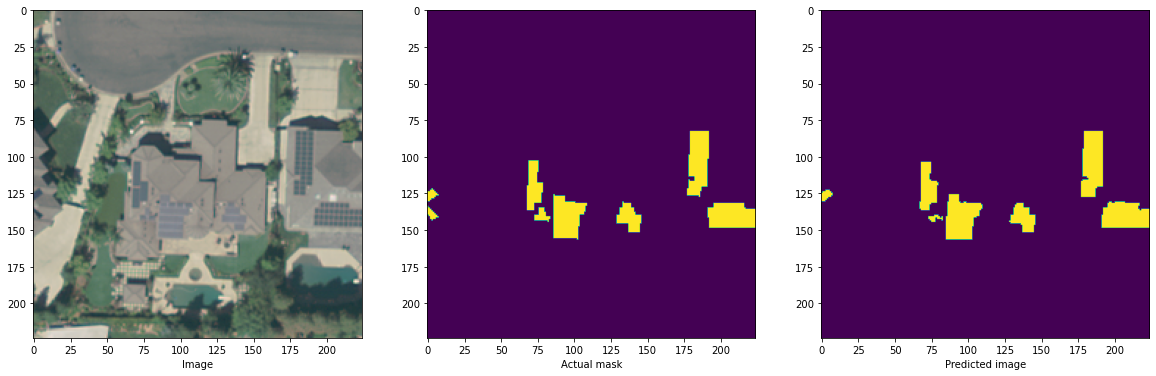

In [83]:
next(ex_iter)